<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early gear fault detection for WT02



## Table of contents
1. Load Raw signal
2. Extract Optimal Bandwidth Based on SK
3. Read Kurtogram Plots
4. Filter Signal with Optimal Bandpass Based on SK
5. Demodulasation Using EEMD Signals
6. Selecting IMF: Correlation Coefficient
7. Envelope Spectral Analyis
8. Envelope Order Analyis
9. Frequency study

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
from scipy.stats import kurtosis, skew

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload 2
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff, data_statistics


appended
appended
appended
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


## 1. Load Raw Signal

In [4]:
turbine = 'wt02'
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox',turbine)
avg_rpm = np.asarray(op_data_intervals['AvgSpeed'])
avg_power = np.asarray(op_data_intervals['AvgPower'])
time = times[0]

wt_folder_path = f'/Volumes/OsvikExtra/signal_data/raw_data/gearbox/{turbine}/'
dates = pd.read_csv(f'{wt_folder_path}interval_dates_{turbine}.csv')
dates = dates.drop(columns=['Unnamed: 0'])


File exist


## 2. Resample Signal into Order Domain

In [5]:
resampled_xs = []
resampled_ys = []
data_size = vib_signal.shape[0]
for i, vib_sig in enumerate(vib_signal):
    x_round, resampled_y, _ = resample_signals.do_cubic_resampling(time, vib_sig, peak_array[i], number_of_resample_points=2000)
    resampled_xs.append(x_round)
    resampled_ys.append(resampled_y)
    print(f'Resampled {i+1} / {data_size} signals', end='\r')


In [ ]:
datasize = len(resampled_xs)
#resampled_wt_path = f'/Volumes/OsvikExtra/signal_data/resampled_order/gearbox/{turbine}/'
resampled_wt_path = f'../../../../../../signal_data/resampled_order/gearbox/{turbine}/'

for i in range(datasize):
    save_path = f'{resampled_wt_path}resampled_order_20000_{i}.csv.zip'
    data = np.array([resampled_xs[i], resampled_ys[i]])
    df = pd.DataFrame(data.T, columns=['order', 'y'])
    df.to_csv(save_path, index=False, compression='gzip')
    print(f'Saved {i+1} / {datasize}', end='\r')
    

## 3. Development of the First 15 Orders

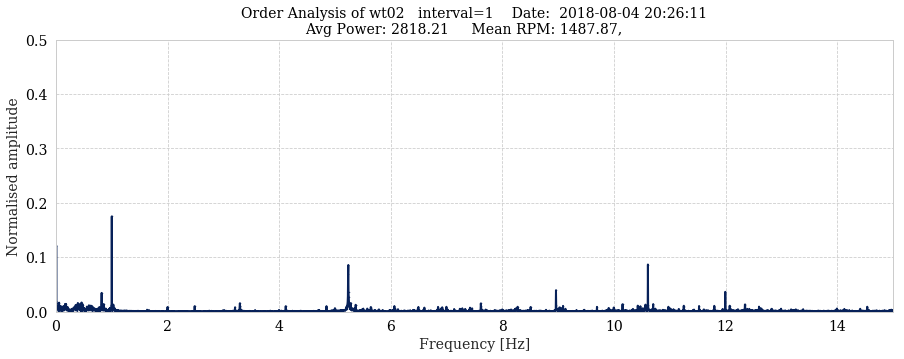

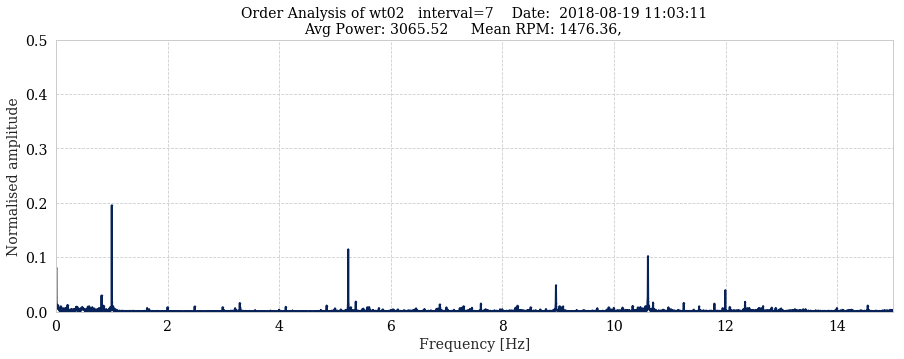

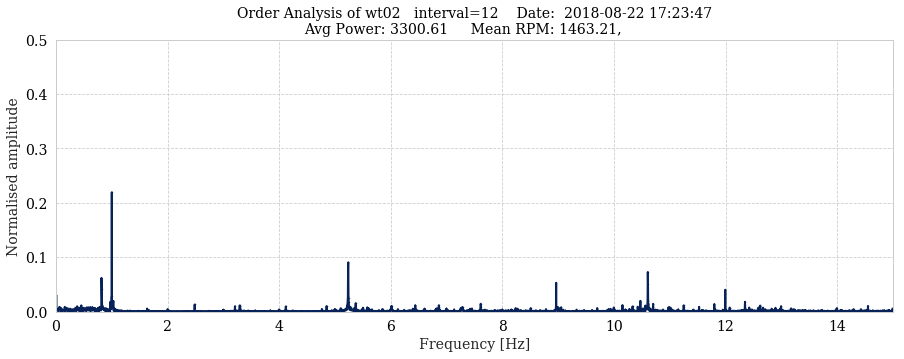

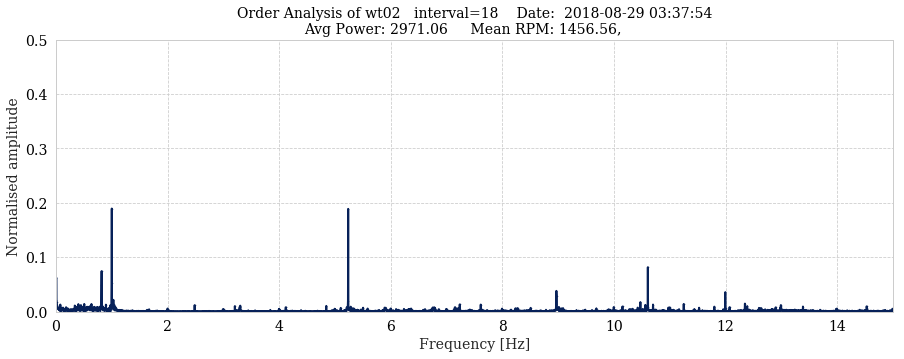

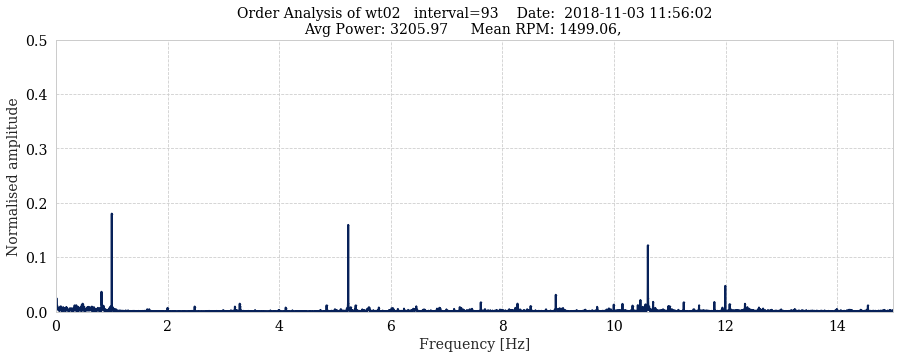

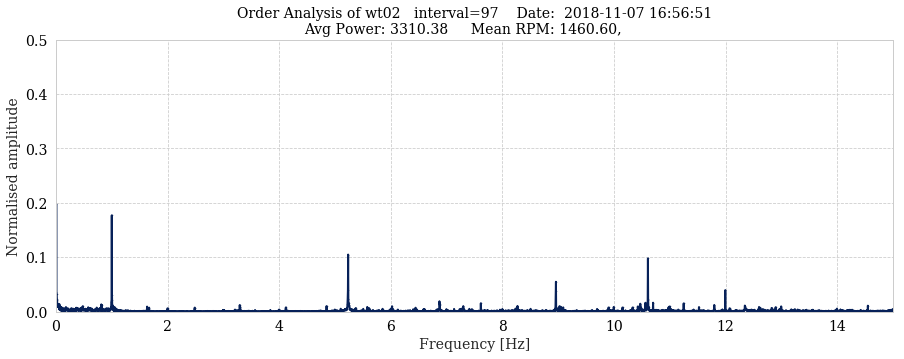

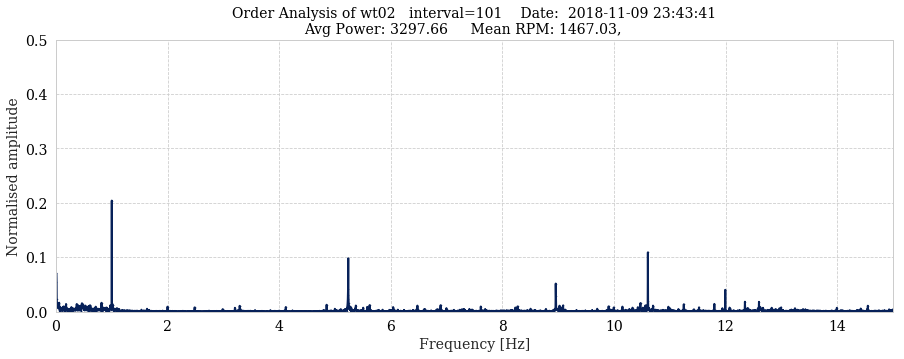

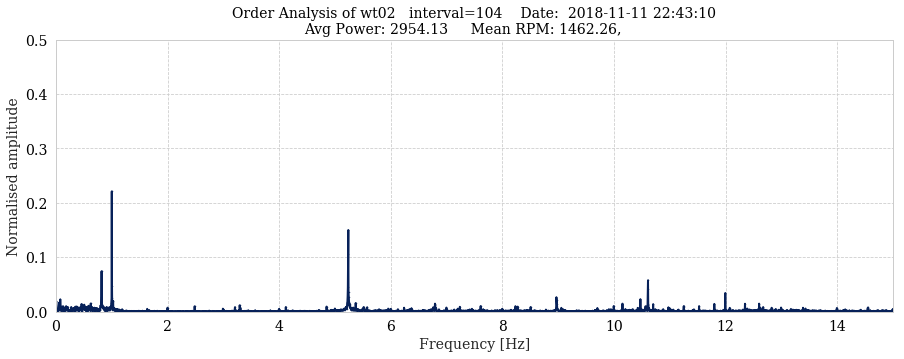

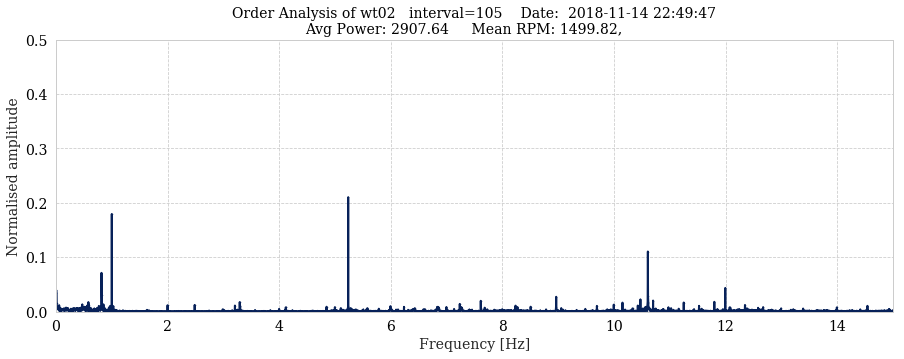

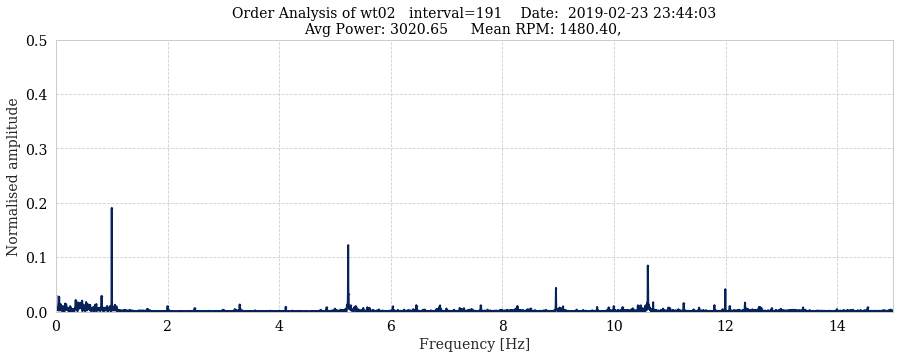

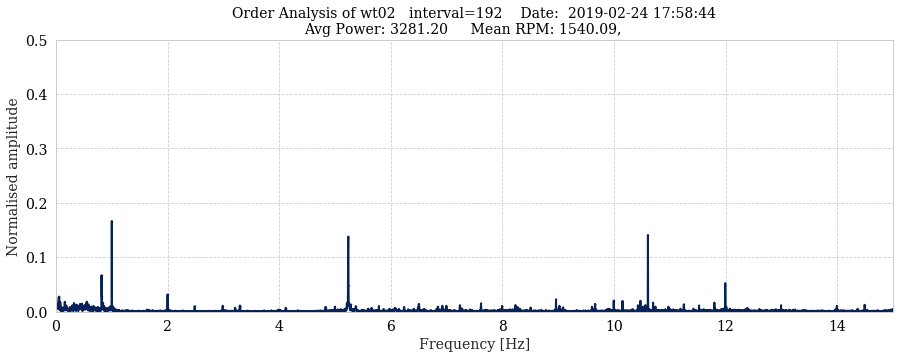

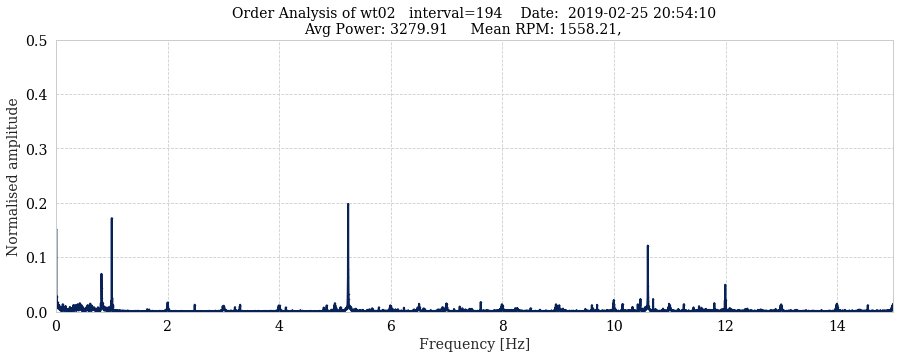

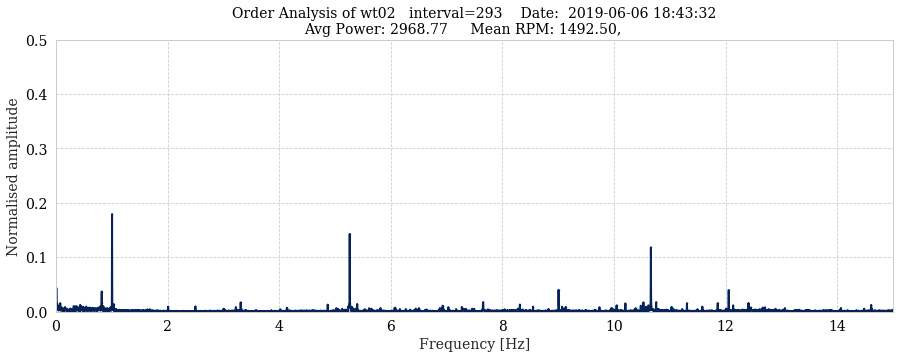

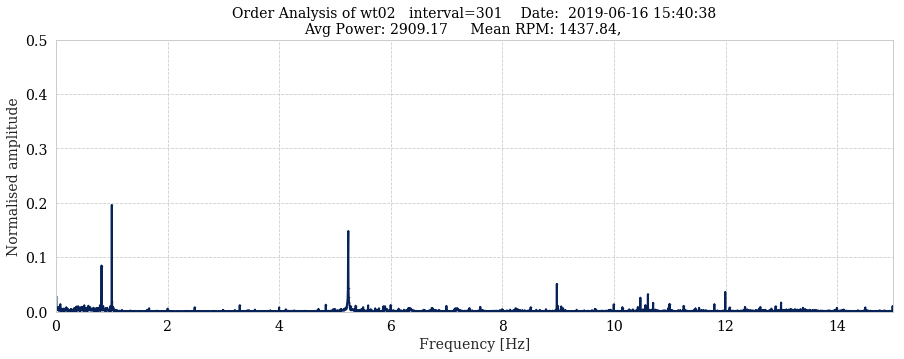

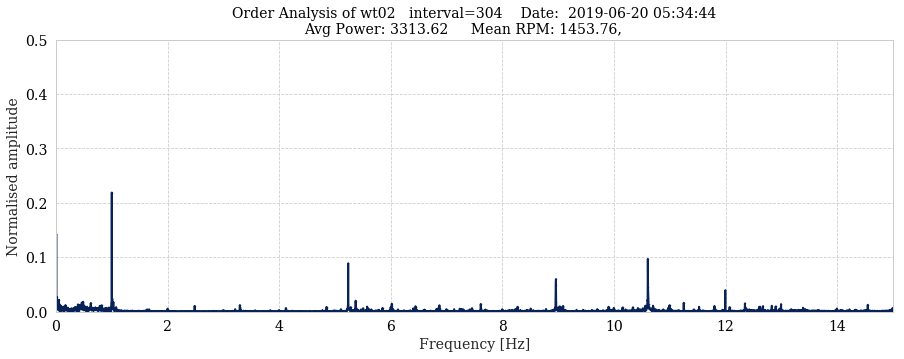

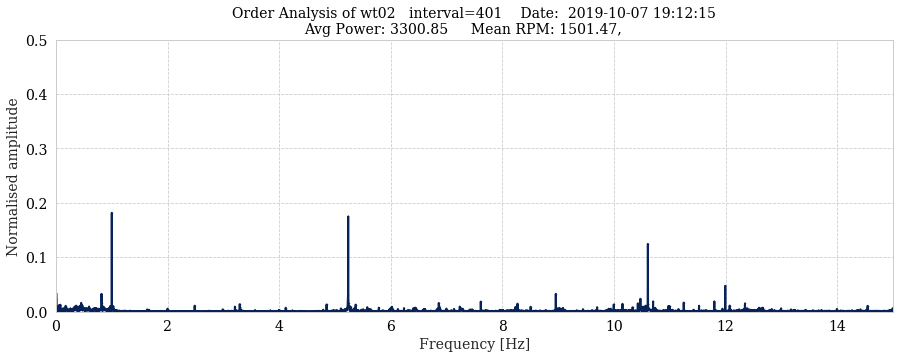

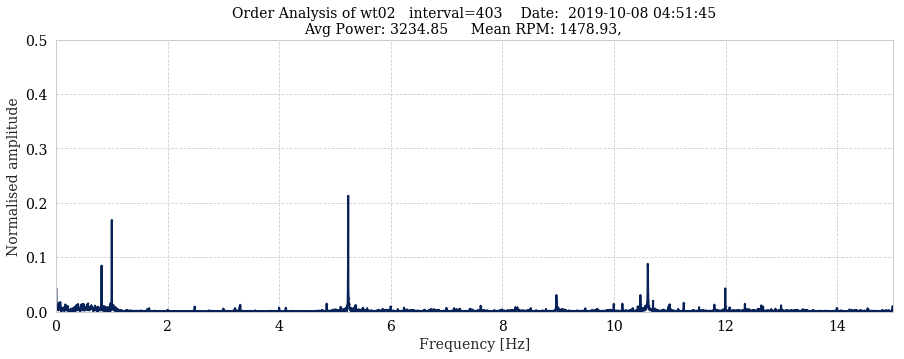

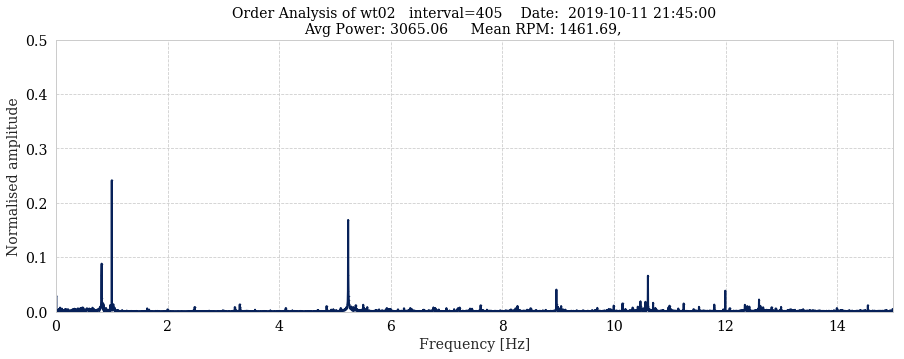

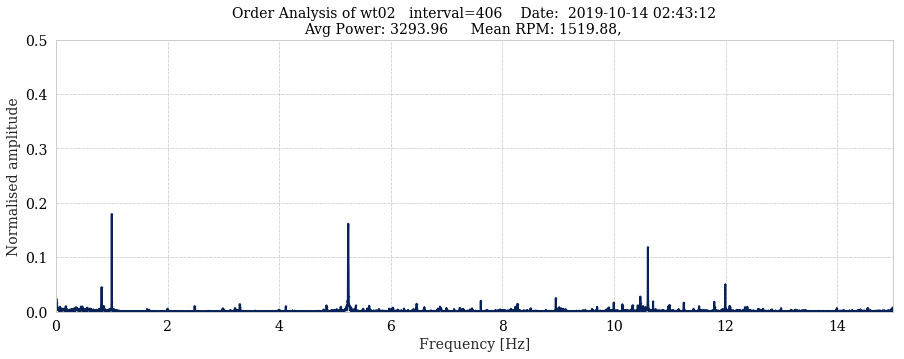

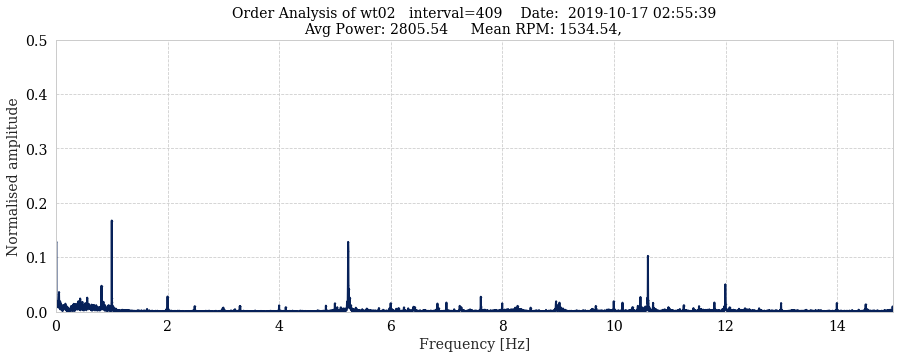

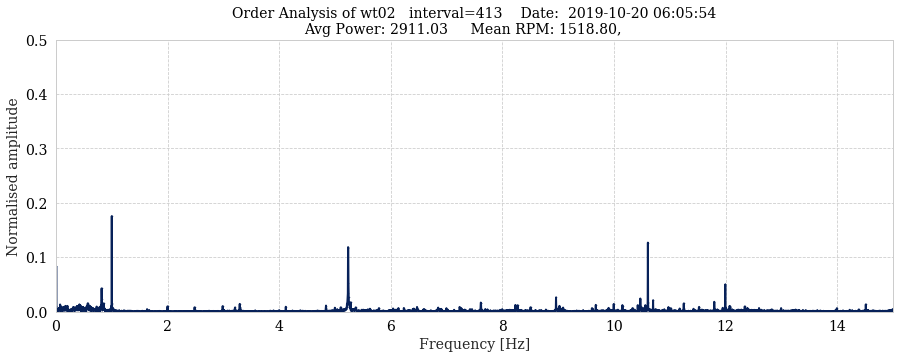

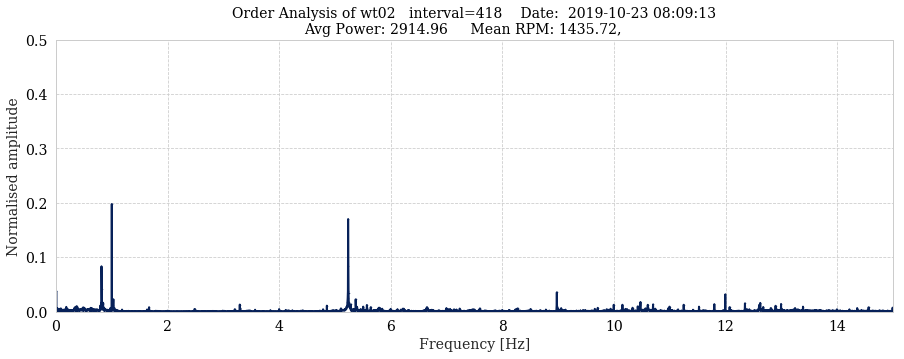

In [13]:
for i, order in enumerate(resampled_xs):
    if ((i < 20) or (i > 90 and i < 110) or (i > 190 and i < 210) or (i > 290 and i < 310) or (i > 400)) and (avg_power[i]>2800):
        title = f'Order Analysis of {turbine}   interval={i}    Date:  {dates.values[i][0]}\n'
        _,_ = plotting_methods.plot_fft(order, resampled_ys[i], x_max=15, y_max=0.5, avg_rpm=avg_rpm[i], avg_power=avg_power[i], name=title, default_title=False)



## 4. Development of the First 200 Orders

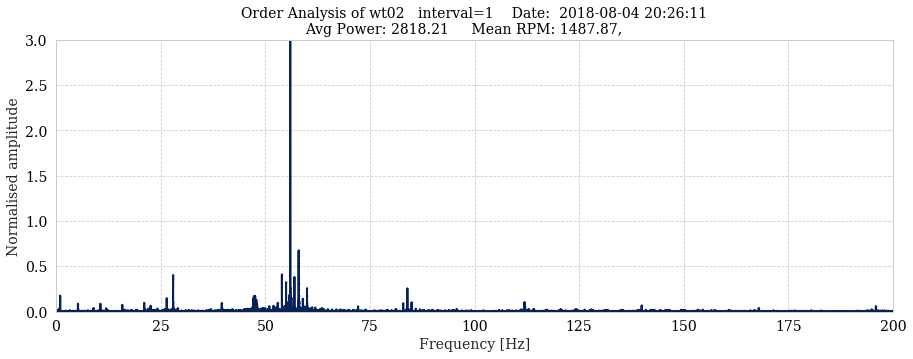

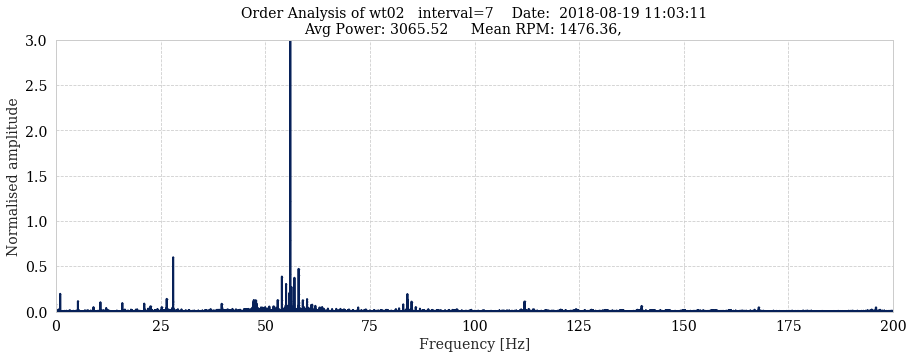

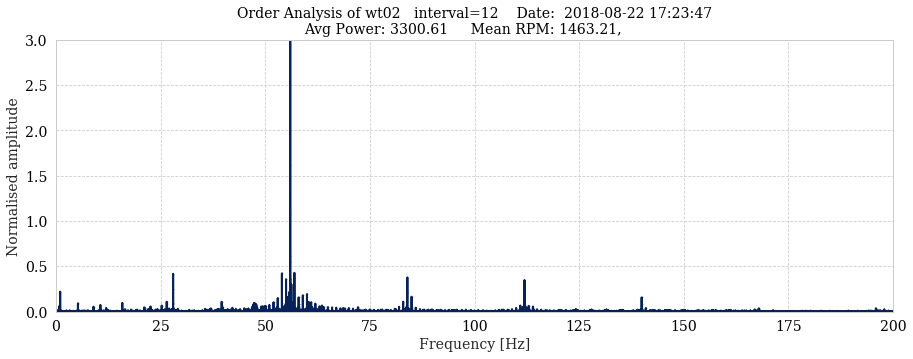

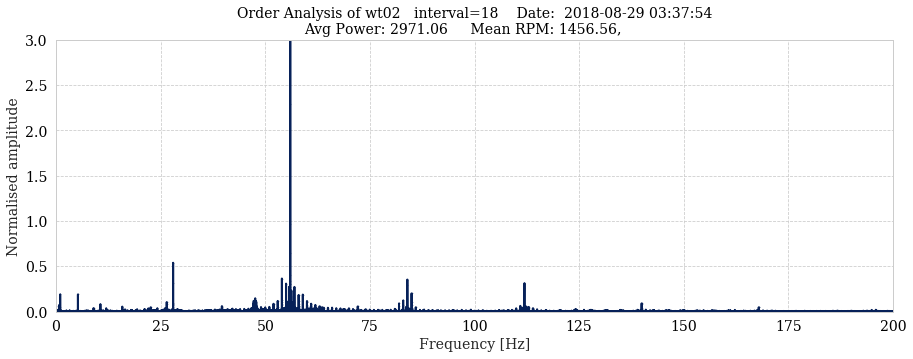

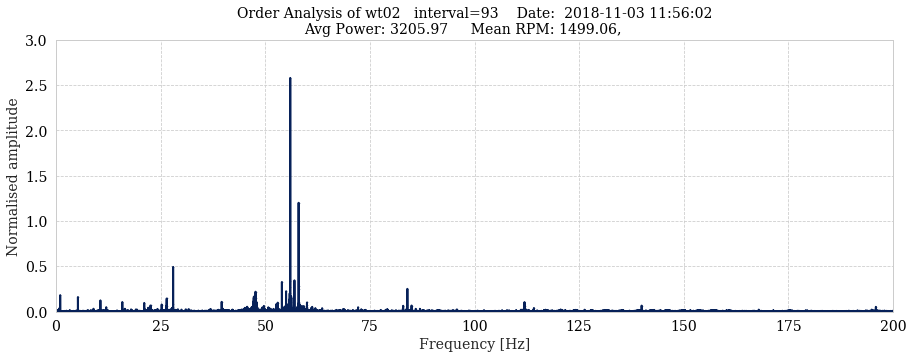

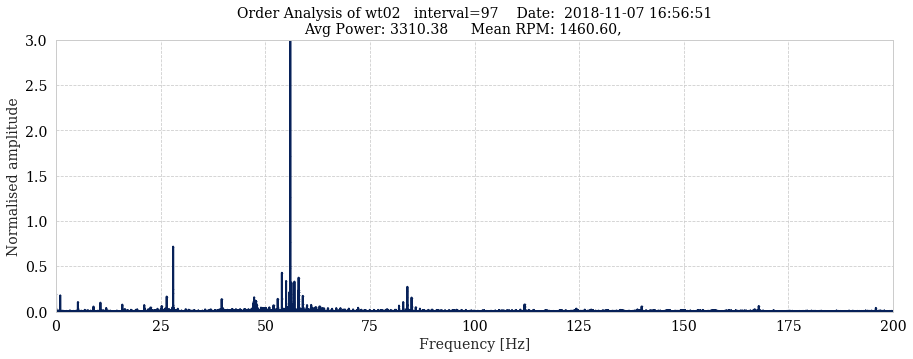

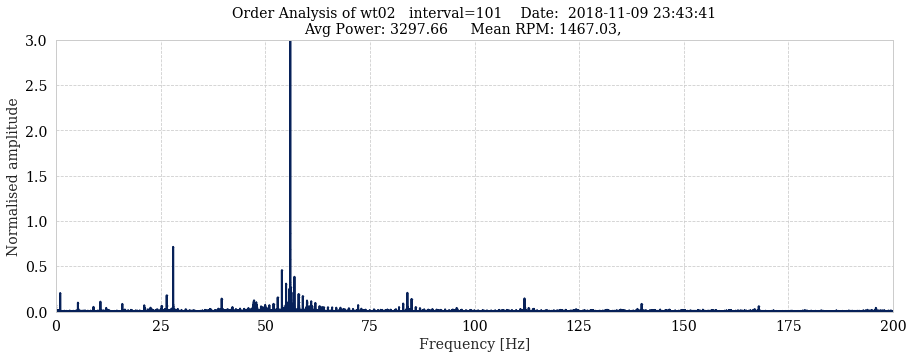

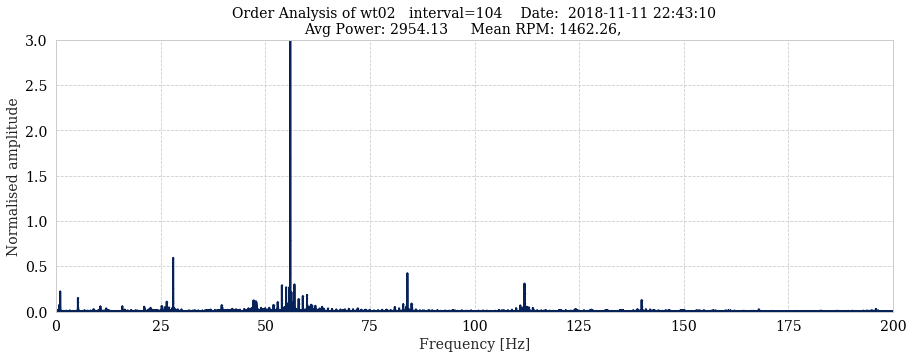

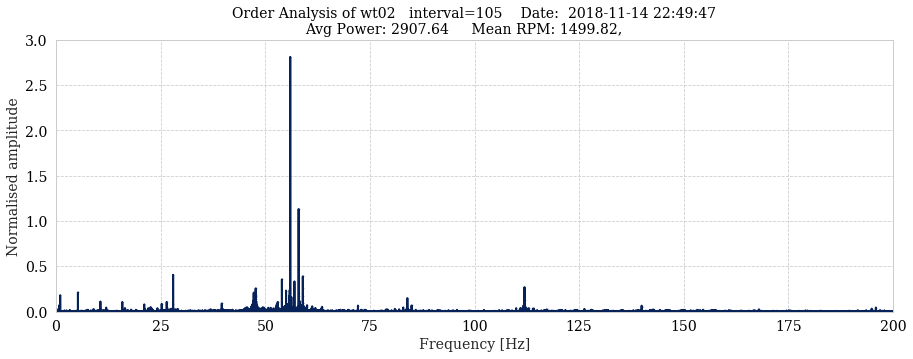

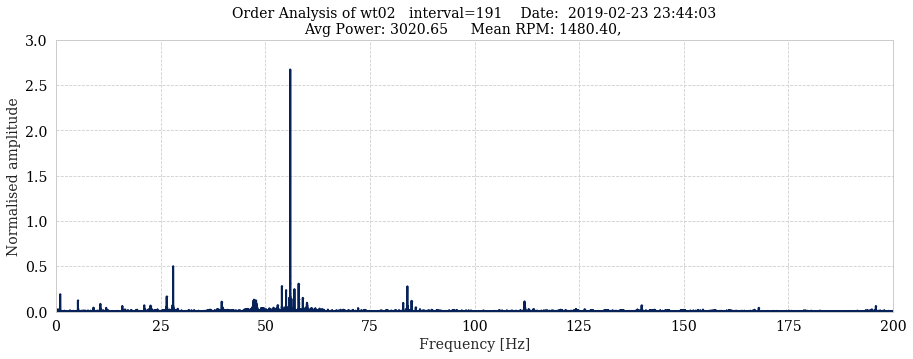

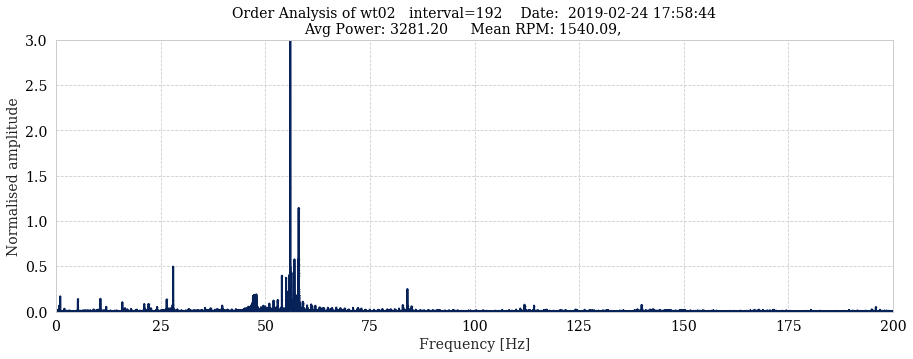

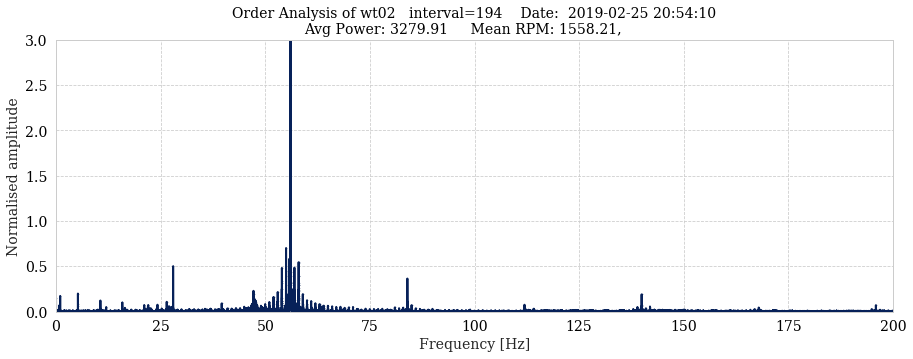

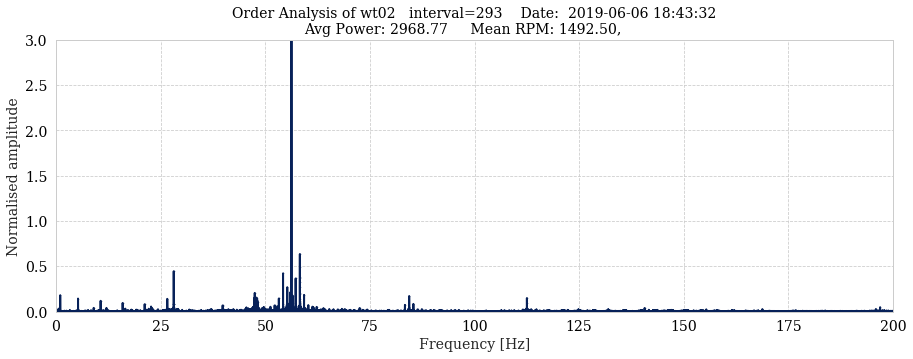

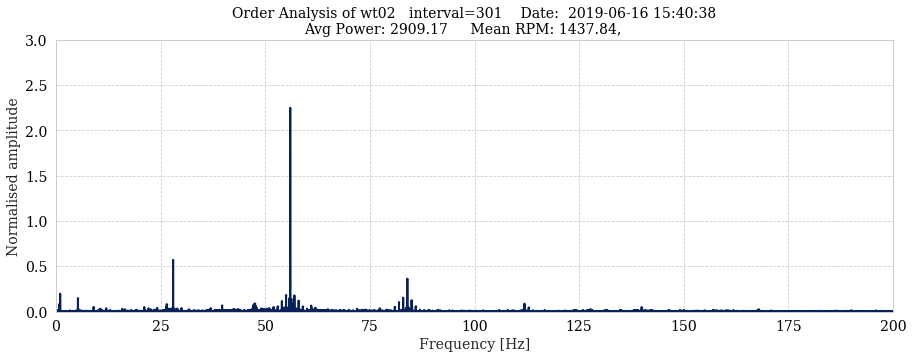

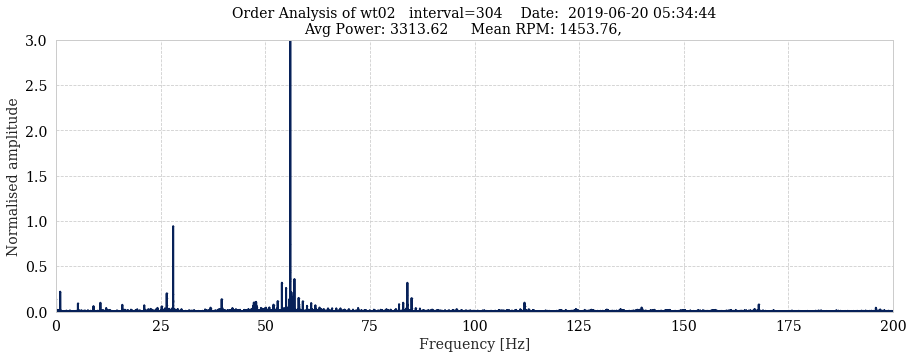

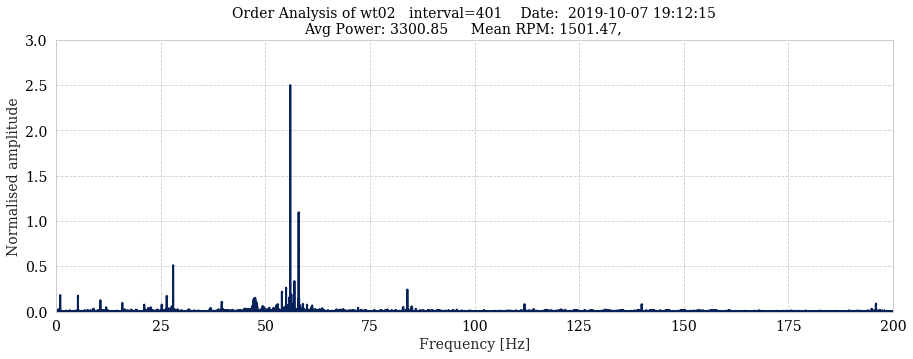

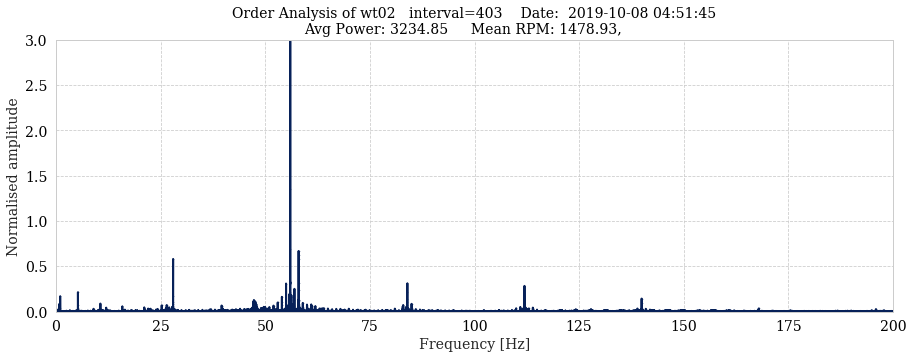

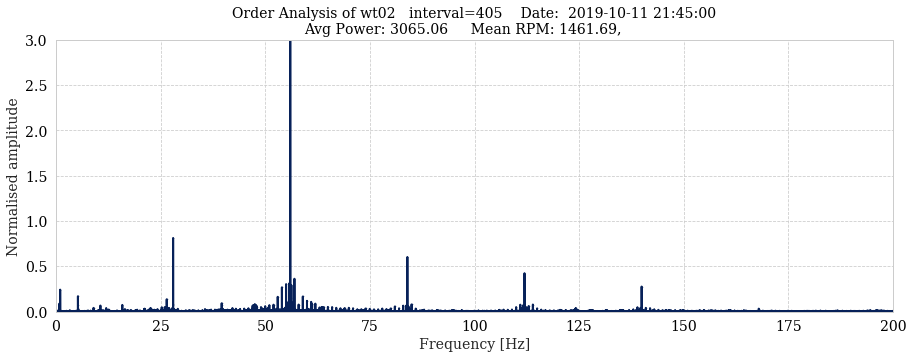

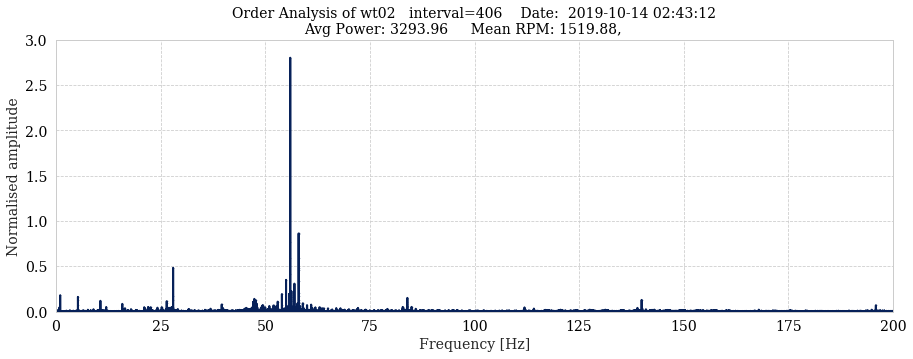

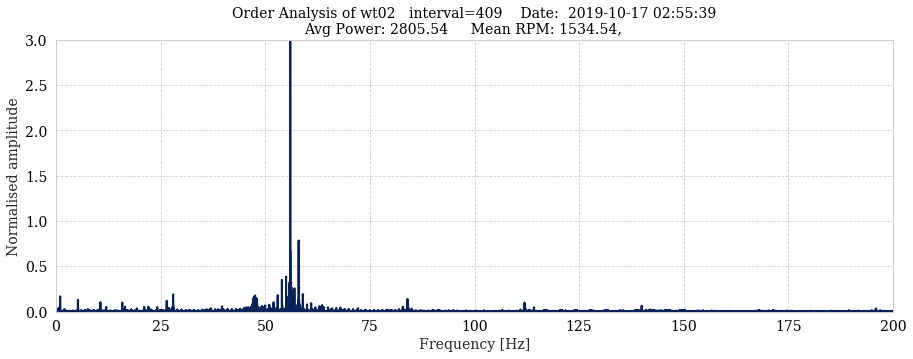

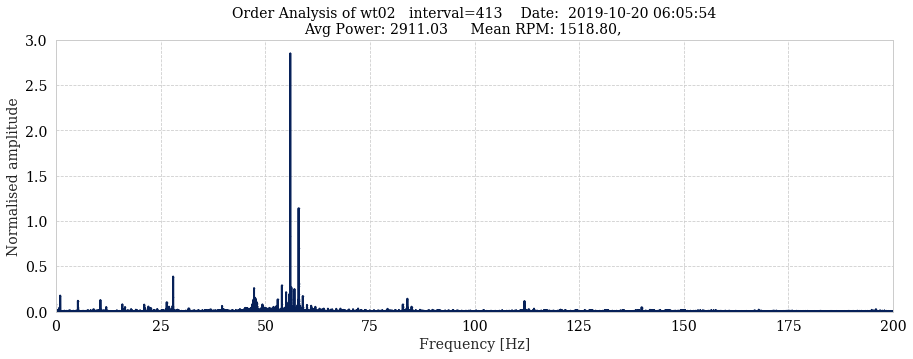

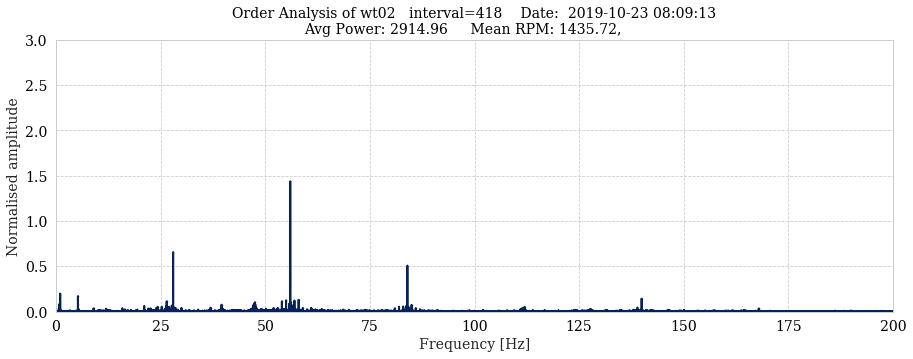

In [14]:
for i, order in enumerate(resampled_xs):
    if ((i < 20) or (i > 90 and i < 110) or (i > 190 and i < 210) or (i > 290 and i < 310) or (i > 400)) and (avg_power[i]>2800):
        title = f'Order Analysis of {turbine}   interval={i}    Date:  {dates.values[i][0]}\n'
        _,_ = plotting_methods.plot_fft(order, resampled_ys[i], x_max=200, y_max=3, avg_rpm=avg_rpm[i], avg_power=avg_power[i], name=title, default_title=False)


## All Orders

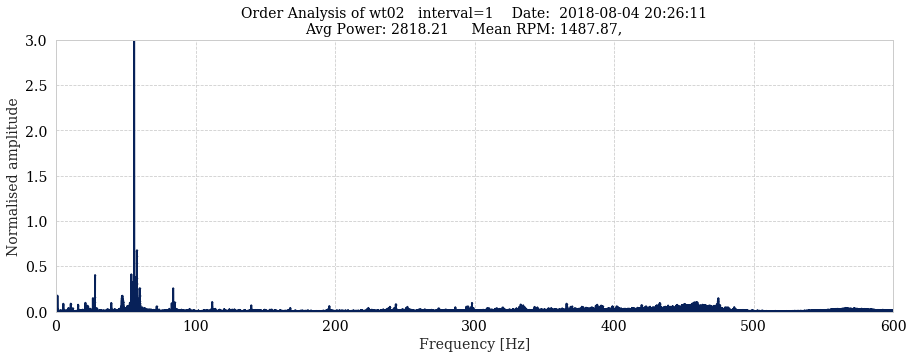

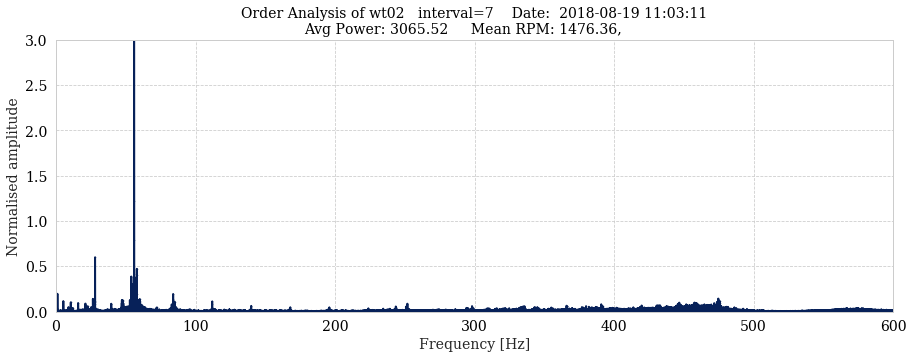

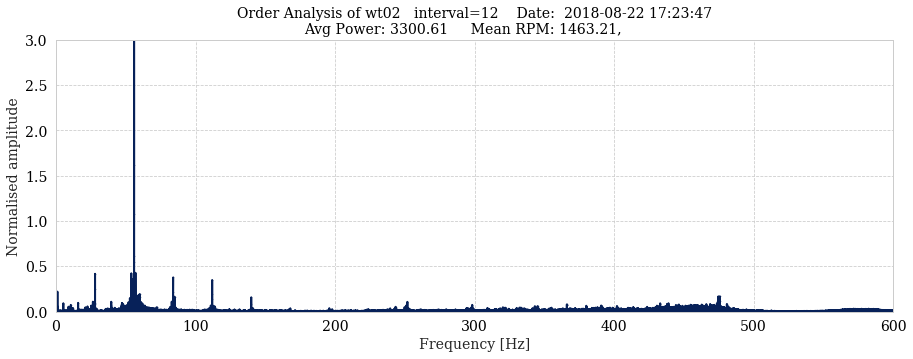

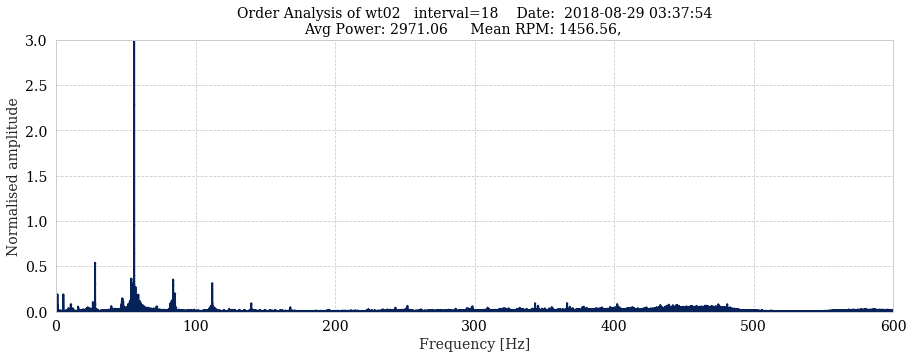

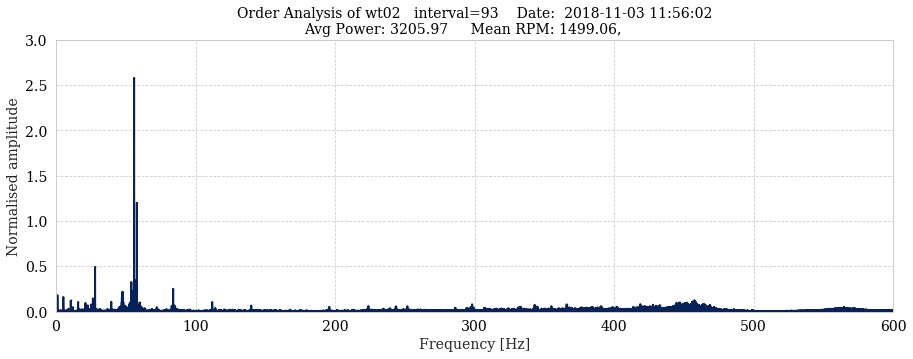

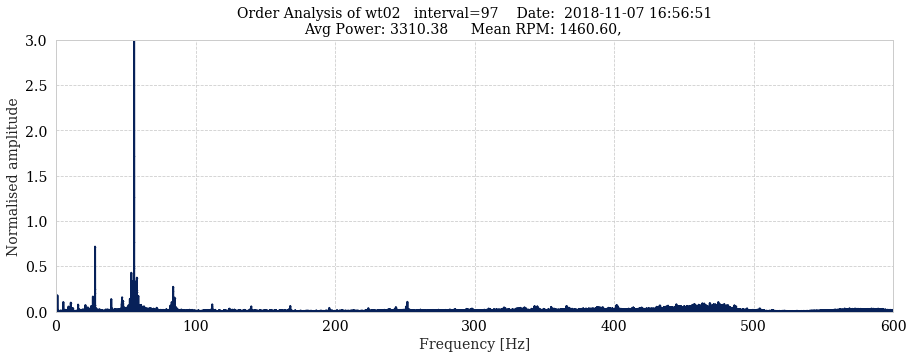

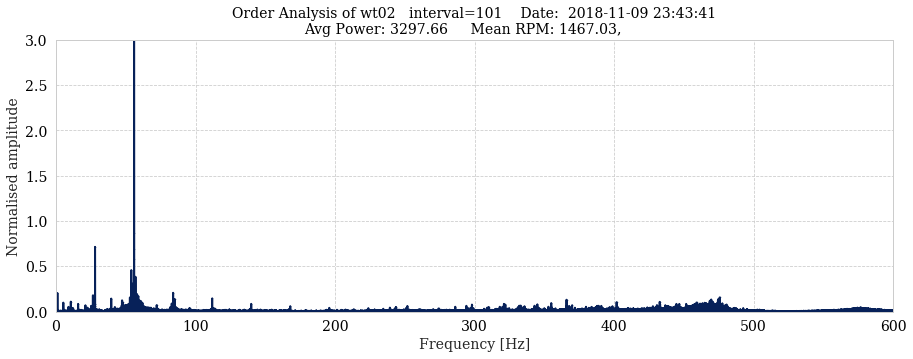

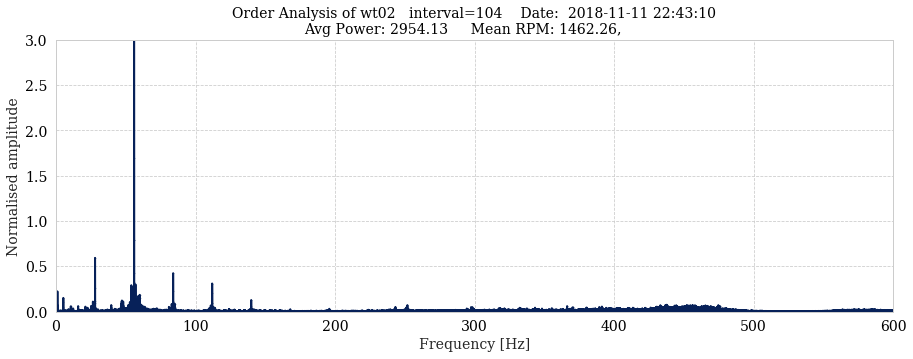

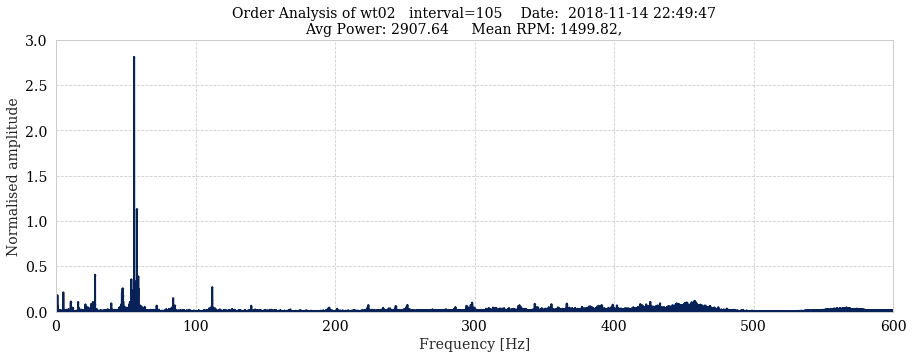

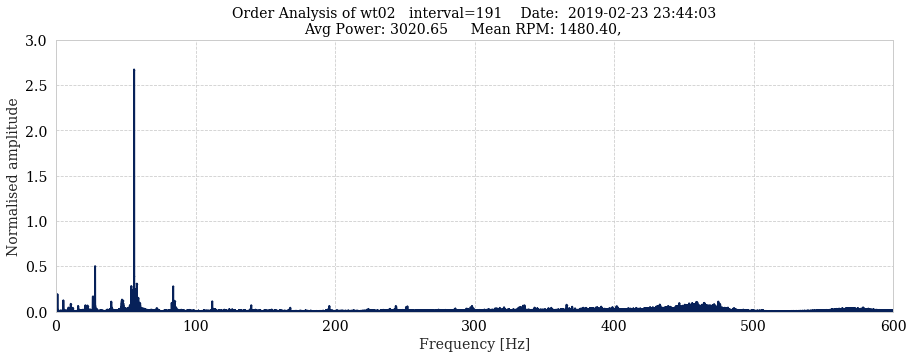

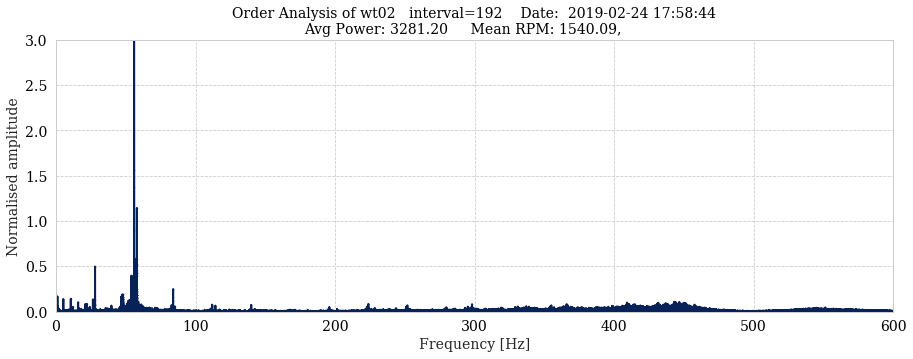

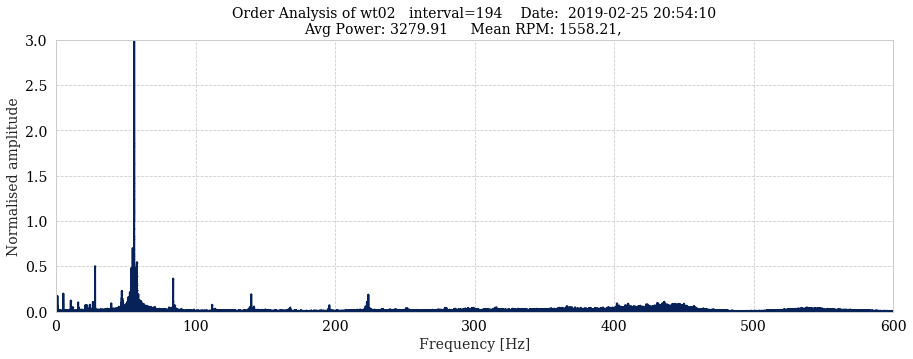

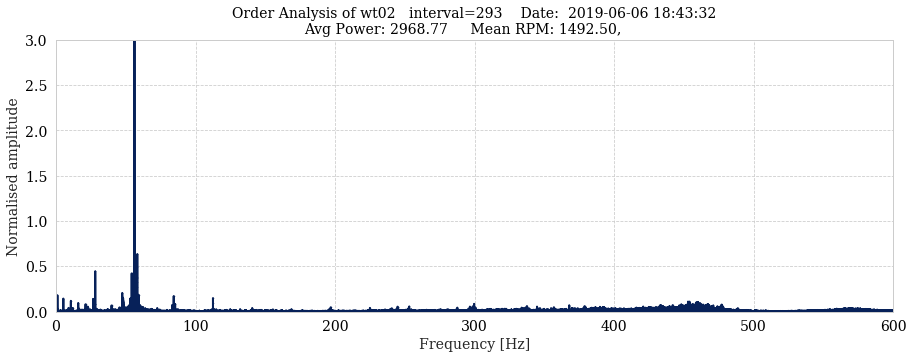

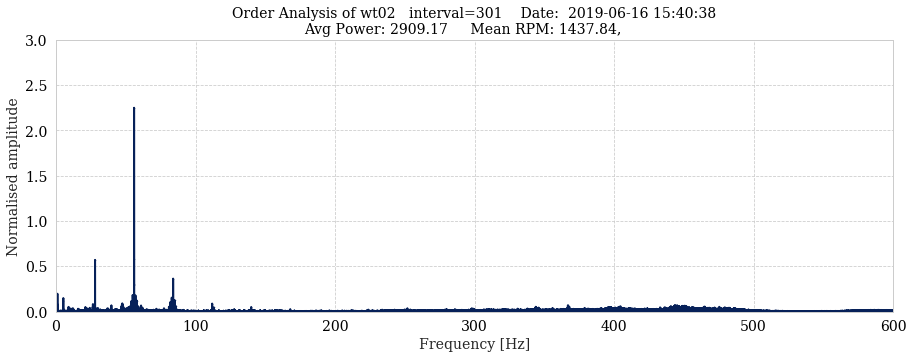

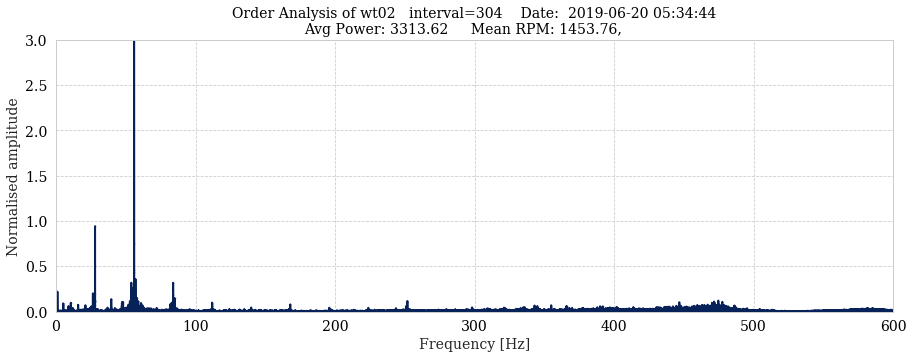

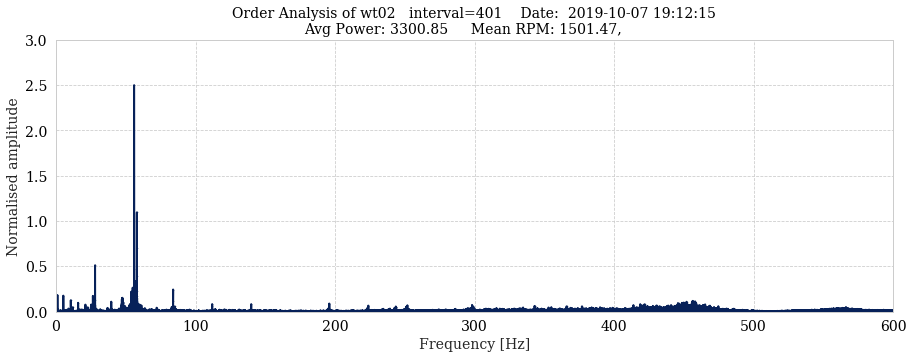

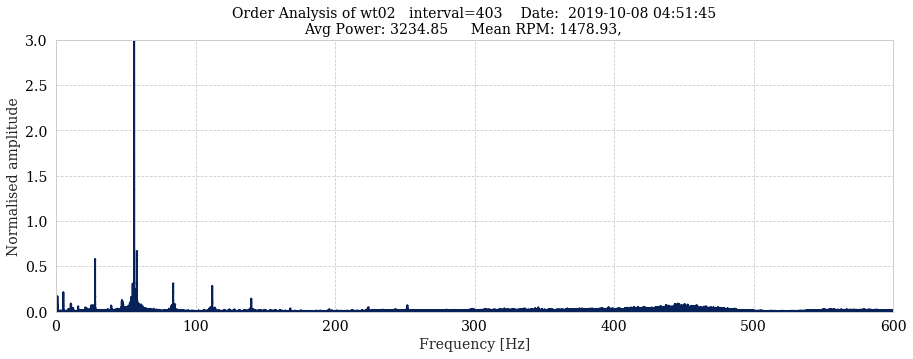

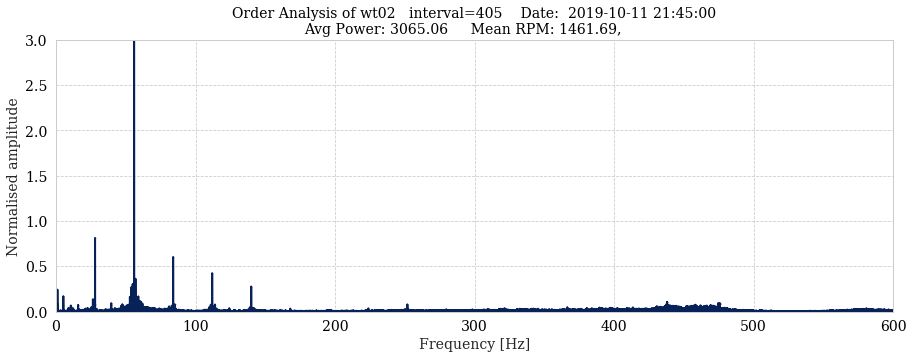

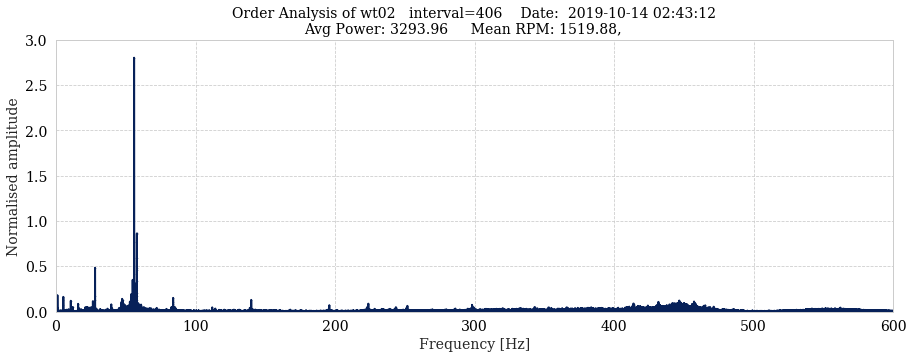

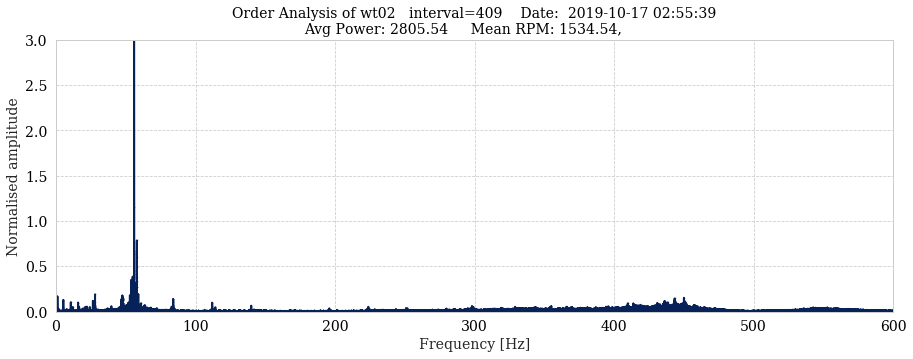

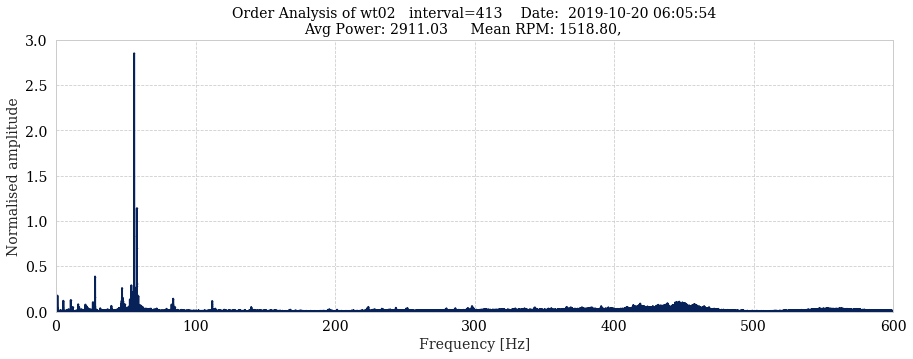

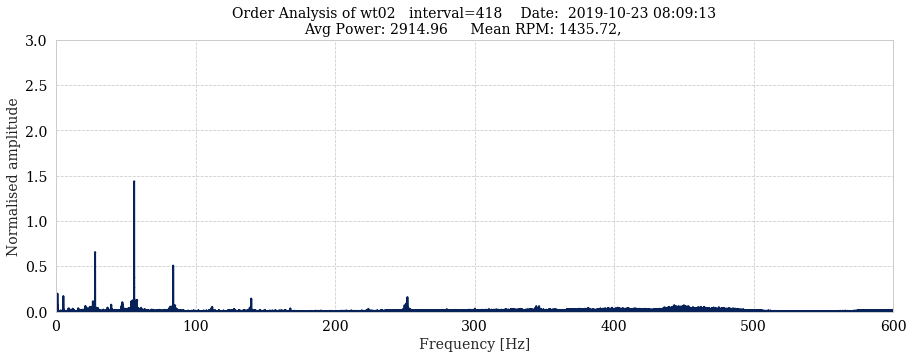

In [16]:
for i, order in enumerate(resampled_xs):
    if ((i < 20) or (i > 90 and i < 110) or (i > 190 and i < 210) or (i > 290 and i < 310) or (i > 400)) and (avg_power[i]>2800):
        title = f'Order Analysis of {turbine}   interval={i}    Date:  {dates.values[i][0]}\n'
        _,_ = plotting_methods.plot_fft(order, resampled_ys[i], x_max=600, y_max=3, avg_rpm=avg_rpm[i], avg_power=avg_power[i], name=title, default_title=False)


## RMS all Signals wtih Avg Power > 2700

In [6]:
def normalise_fft(fft):
    N = fft.shape[0]
    y = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    return y

all_fft_x = []
all_fft_y = []

for i, order in enumerate(resampled_xs):
    if (avg_power[i]>2700):
        fft_res, freq_res = plotting_methods.plot_fft(resampled_xs[i], resampled_ys[i], x_max=500, y_max=None, avg_rpm=avg_rpm[i], avg_power=avg_power[i])
        all_fft_x.append(freq_res)
        all_fft_y.append(normalise_fft(fft_res))
    print(i, end='\r')

In [7]:
def rms_bin(amp):
        sum = 0
        for a in amp:
            sum += a ** 2
        rms = np.sqrt(2 * sum)
        return rms

In [8]:

bins = 50000

all_rms = []
all_x   = []
    
for j in range(len(all_fft_x)):
    f = all_fft_x[j]
    y_norm = all_fft_y[j]
    rms_bins = []
    frequency_bins = np.linspace(0, max(f), bins + 1)
    frequency_bins = np.linspace(0, 500, bins + 1)
    if True:
        delta_f = f[1] - f[0]

        # Finding the correct indices to separate frequency and amplitude correctly.
        bin_indexes = [0]
        # Since the first index is already added to bin_indexes we start frequency_bins_index at 1
        frequency_bins_index = 1
        for i in range(len(f)):
            if frequency_bins_index > bins:
                break
            if f[i] >= frequency_bins[frequency_bins_index]:
                frequency_bins_index += 1
                bin_indexes.append(i)
        for i in range(len(bin_indexes) - 1):
            amp = y_norm[bin_indexes[i]:bin_indexes[i + 1]]  # Calculating the rms between two indexes
            rms_bins.append(rms_bin(amp))
            #rms_bins.append(np.mean(amp))
    x = [(frequency_bins[a] + frequency_bins[a + 1]) / 2 for a in
         range(len(frequency_bins) - 1)]  # The frequency index for the bins!
    
    all_rms.append(rms_bins)
    all_x.append(x)
    print(j, end='\r')


Real: 55.97321423452944
Simulated: 55.975


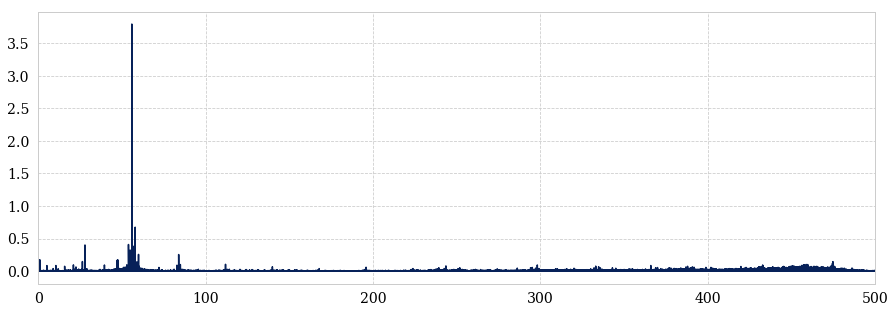

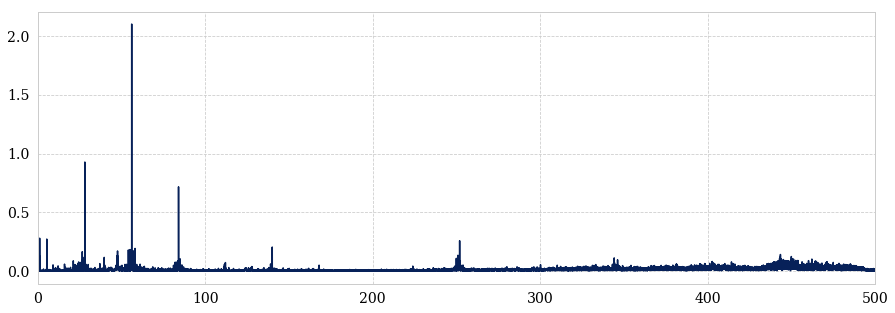

Real: 55.97323042902895
Simulated: 55.975


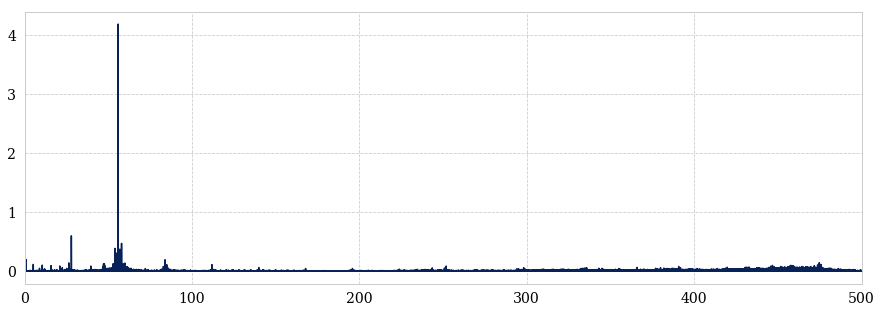

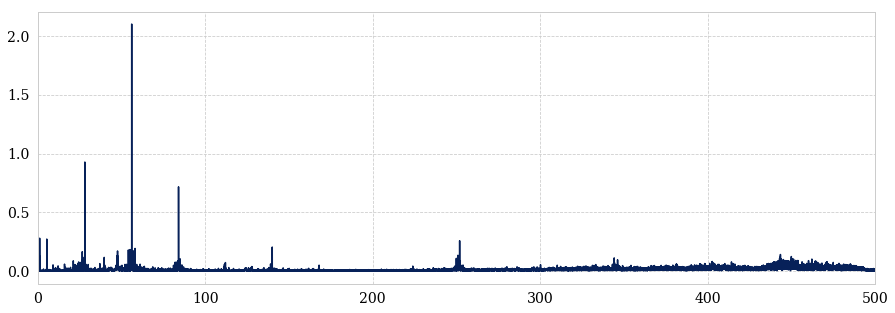

Real: 55.97328273310997
Simulated: 55.975


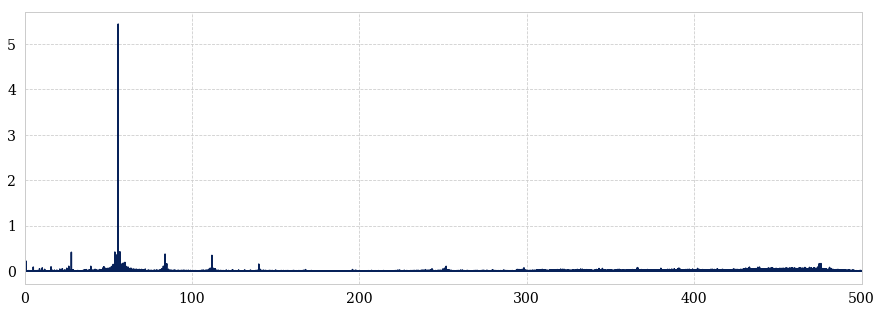

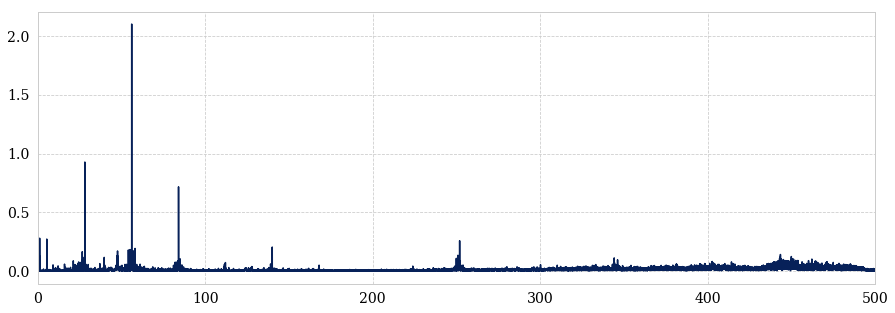

Real: 55.97327817427231
Simulated: 55.975


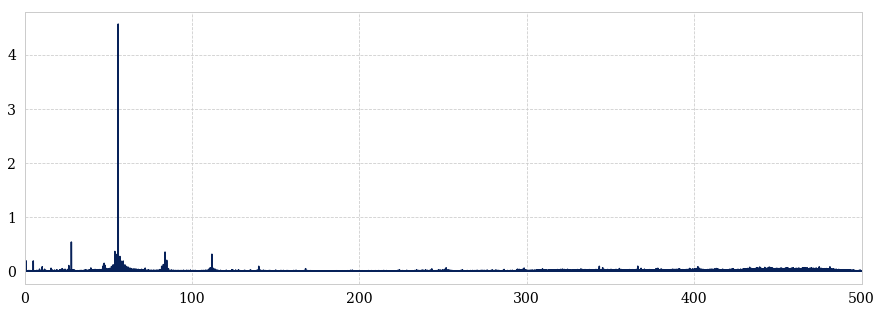

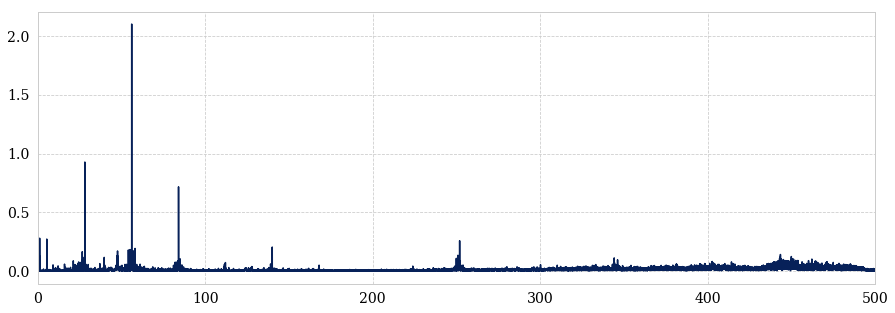

Real: 55.973240273285604
Simulated: 55.975


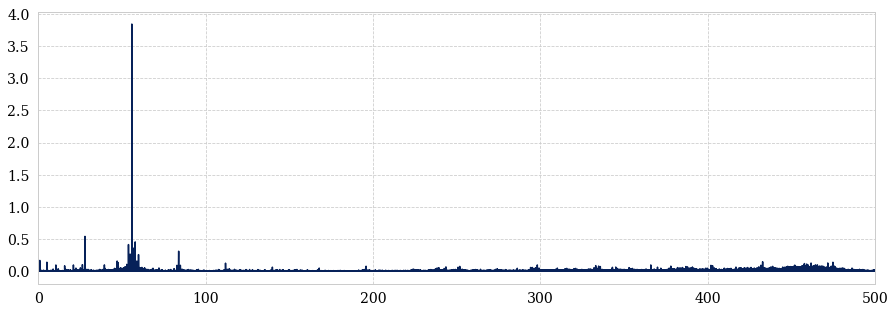

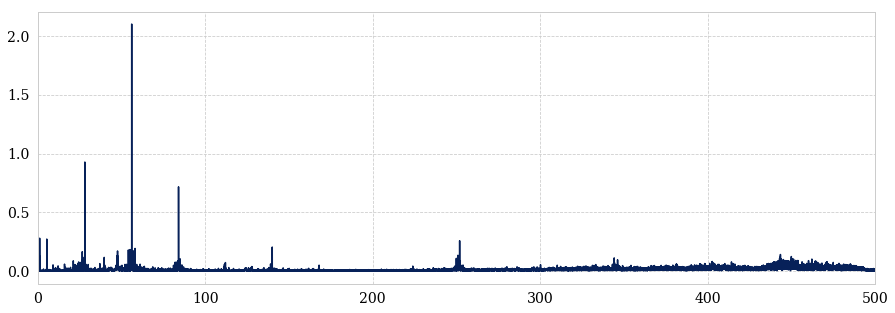

Real: 55.97321423452944
Simulated: 55.975


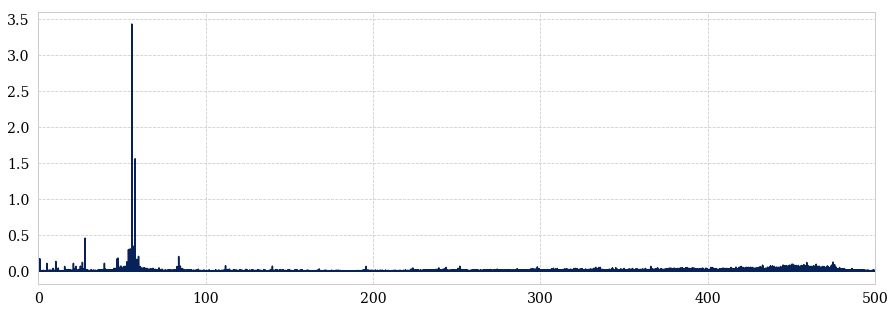

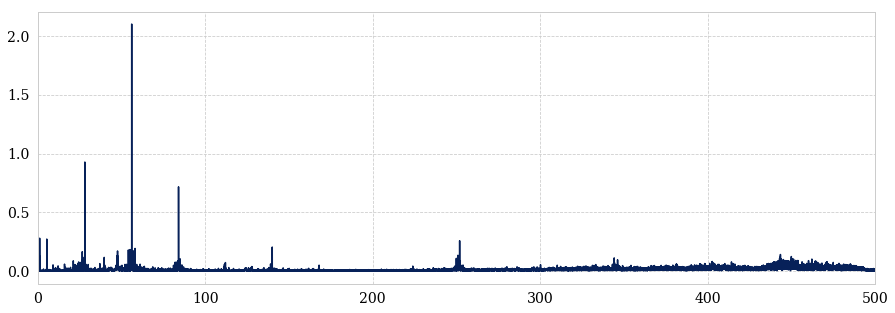

Real: 55.9732385316203
Simulated: 55.975


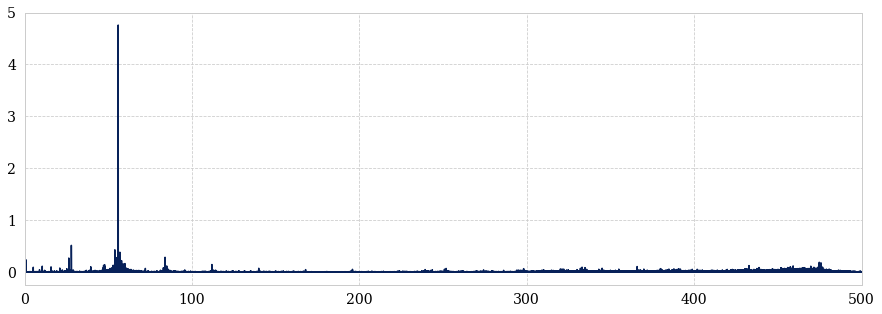

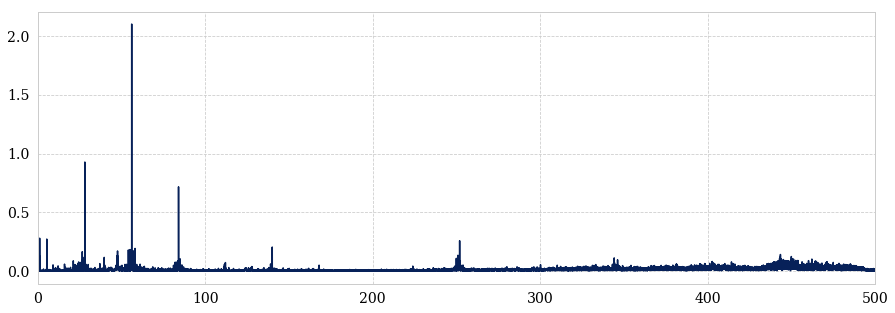

Real: 55.973266736778314
Simulated: 55.975


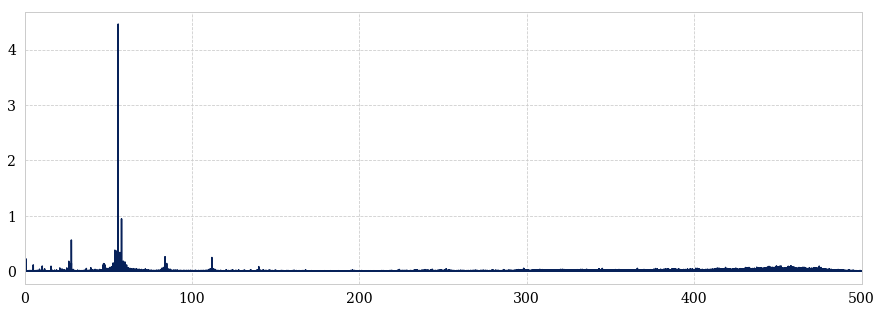

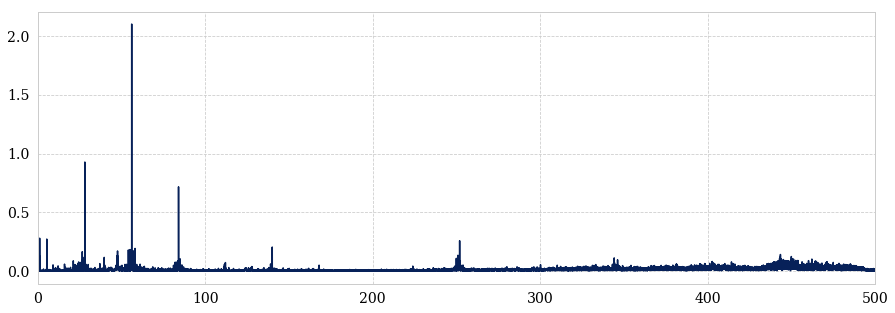

Real: 55.97324071182388
Simulated: 55.975


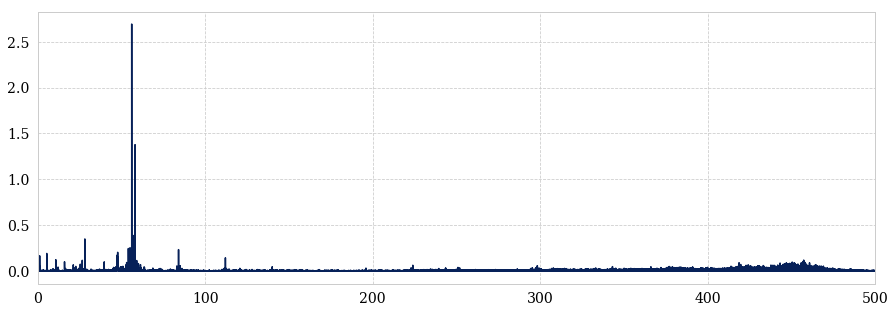

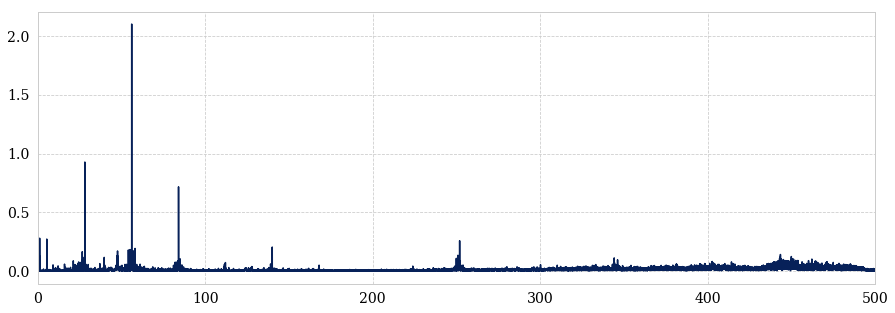

Real: 55.97324157942601
Simulated: 55.975


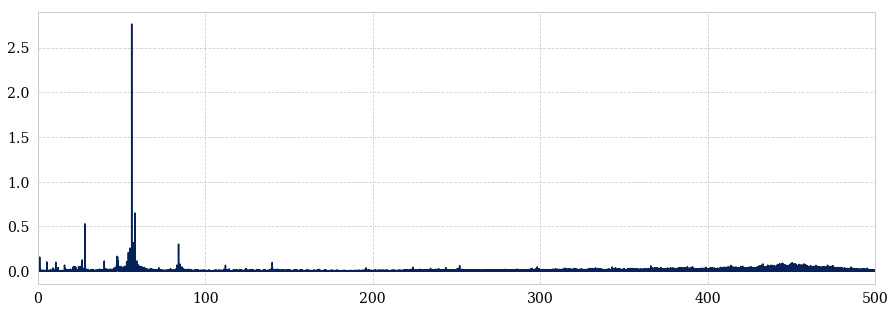

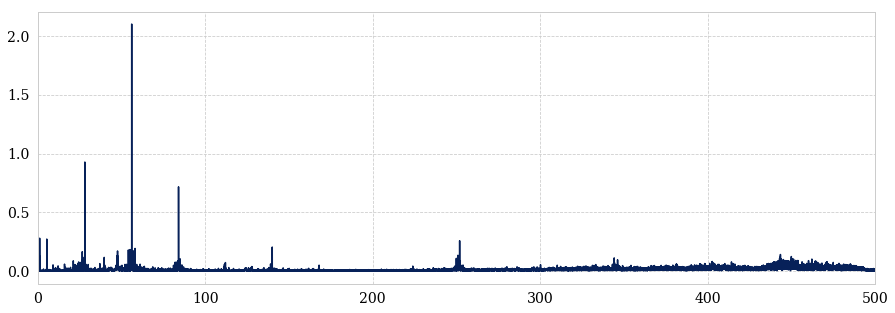

In [10]:
for i in range(10):
    print(f'Real: {all_fft_x[i][np.argmax(all_fft_y[i])]}')
    print(f'Simulated: {all_x[i][np.argmax(all_rms[i])]}')
    
    plt.figure(figsize=(15,5))
    plt.plot(all_fft_x[i], all_fft_y[i])
    plt.xlim(0,500)
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(x,rms_bins)
    plt.xlim(0,500)
    plt.show()

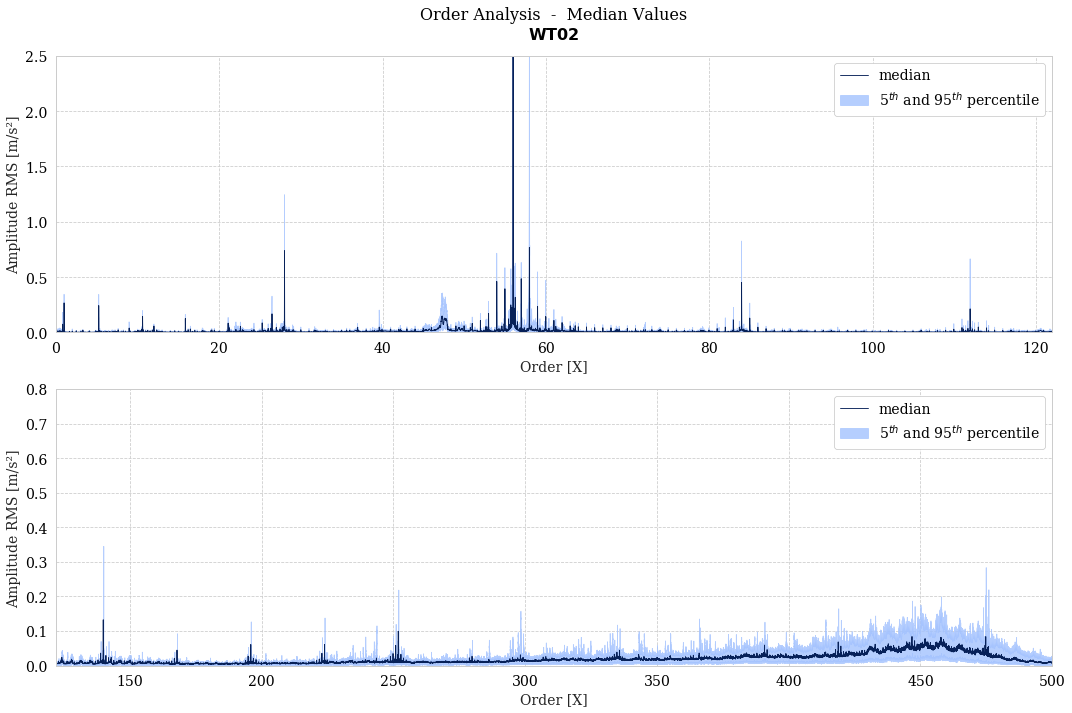

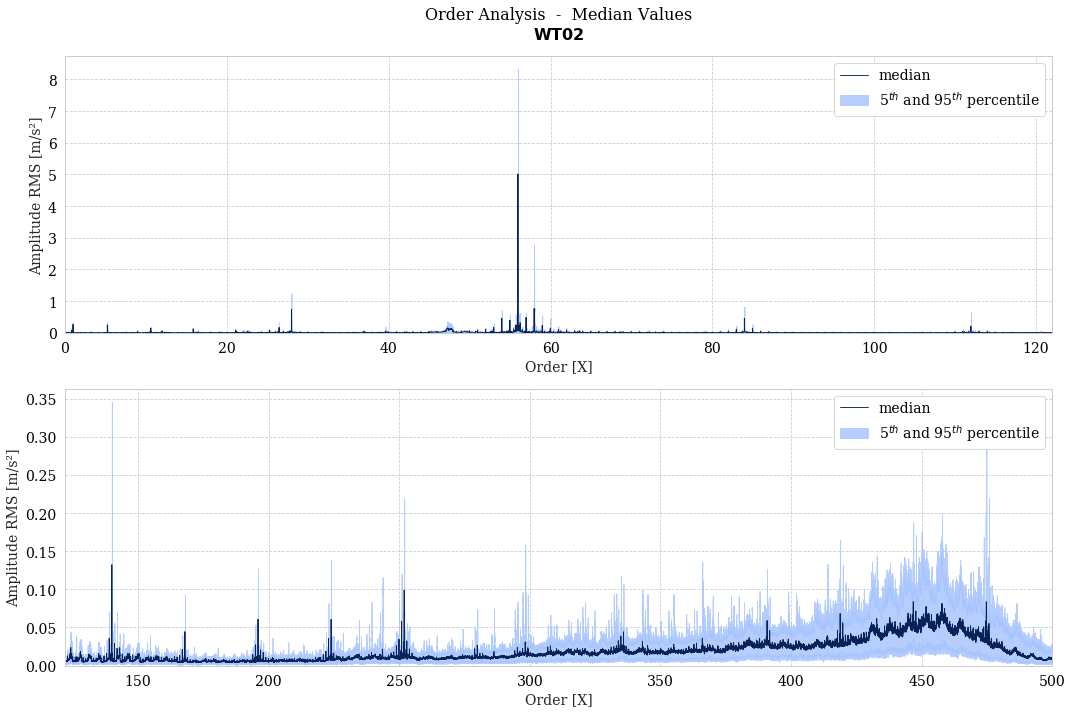

In [15]:
rms_df = pd.DataFrame(all_rms)
plot_path = f'../../plots/results/rms_orders_{turbine}_equal_scale'
heading = 'Order Analysis  -  Median Values\n' + r"$\bf{WT02}$"
data_statistics.plot_median_rms(rms_df, x=np.asarray(all_x[0]), split=True, save_path=plot_path, y_max=2.5, y_max2=0.8, title=heading)
data_statistics.plot_median_rms(rms_df, x=np.asarray(all_x[0]), split=True, save_path=None, title=heading)